In [72]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial
import ot
from tqdm import tqdm
from sklearn.manifold import MDS
from sklearn.cluster import SpectralClustering
import pandas as pd

In [348]:
atom_ids=[2, 5, 6, 7, 9, 11, 15, 16, 17, 19] #if necessary
atom_numbers = np.array([6,6,8,7,6,6,6,8,7,6])
species = ['C','C','O','N','C','C','C','O','N','C']

filename='../data/ala2-positions/COLVAR'
headers = pd.read_csv(filename,sep=' ',skipinitialspace=True, nrows=0).columns[2:]  
df = pd.read_csv(filename,sep=' ',skipinitialspace=True, header=None,skiprows=1,names=headers,comment='#') 

#select subset of columns based on names
pos = df.filter(regex='p_')

#save features names and np array
names = pos.columns
array = pos.values

In [180]:
positions = np.reshape(np.array(pos),(1001, 10, 3))

In [325]:
phi = df['phi']
state = np.zeros_like(phi)
state[ (phi > 0 ) & (phi <2.5)] = 1 
state_B = np.array(state, dtype=np.bool)
state_A = np.logical_not(state_B)

<AxesSubplot:>

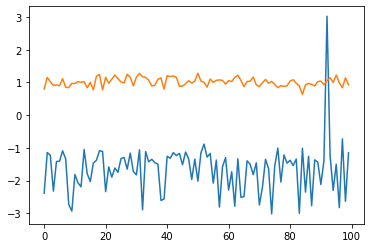

In [386]:
num_samples = 100
posA = positions[state_A]
posB = positions[state_B]

perm_A = np.random.permutation(posA.shape[0])
perm_B = np.random.permutation(posB.shape[0])

train_A = perm_A[:num_samples]
train_B = perm_B[:num_samples]

test_A = perm_A[num_samples:]
test_B = perm_B[num_samples:]

df['phi'][state_A].reset_index()['phi'][train_A].reset_index()['phi'].plot()
df['phi'][state_B].reset_index()['phi'][train_B].reset_index()['phi'].plot()

In [405]:
def similarity_matrix(configurations, normalize = True, with_tqdm=True):
    n_config, n_dims, _ = configurations.shape
    arr = []
    if with_tqdm:
        iterator = tqdm(range(n_config))
    else:
        iterator = range(n_config)
        
    for idx in iterator:
        config = configurations[idx]*10 #10 factor to move in Angstrom
        config = np.c_[atom_numbers, config]
        cond_form = scipy.spatial.distance.pdist(config, coulomb_distance)
        #cond_form = scipy.spatial.distance.pdist(config, 'cosine')      
        arr.append(scipy.spatial.distance.squareform(cond_form)) 
    if normalize:
        mean = np.mean(np.array([np.max(x) for x in arr]))
        norm_arr = [x/mean for x in arr]
        return norm_arr
    else:
        return arr
def coulomb_distance(v, u):
    e_2 = 14.399 # in eV*Angstrom
    return u[0]*v[0]*e_2/np.linalg.norm(u[1:] - v[1:])

In [388]:
C_A = similarity_matrix(posA[train_A], normalize = False)
C_B = similarity_matrix(posB[train_B], normalize = False)

C_test_A = similarity_matrix(posA[test_A], normalize = False)
C_test_B = similarity_matrix(posB[test_B], normalize = False)

100%|██████████| 638/638 [00:00<00:00, 2343.56it/s]


In [396]:
def build_adjacency_matrix(C_list, with_tqdm=True):
    num_atoms = C_list[0].shape[0]
    num_samples = len(C_list)
    adj_mat = np.empty((num_samples, num_samples))
    if with_tqdm:
        iterator = tqdm(range(num_samples))
    else:
        iterator = range(num_samples)
    for C_i in iterator:
        for C_j in range(C_i + 1):
            C1 = C_list[C_i]
            C2 = C_list[C_j]
            #p = np.ones(num_atoms)/num_atoms
            p = atom_numbers/np.sum(atom_numbers)
            q = p
            if C_i == C_j:
                adj_mat[C_i, C_i] = 0
            else:
                gw_dist = np.sqrt(ot.gromov.gromov_wasserstein2(C1, C2, p, q, 'square_loss')) #The package OT actually computes the square distance (check Refs by Peyre and Memoli)
                adj_mat[C_i, C_j] = gw_dist
                adj_mat[C_j, C_i] = gw_dist
    return adj_mat      

In [390]:
adj_mat = build_adjacency_matrix(C_A + C_B)

100%|██████████| 200/200 [00:13<00:00, 14.62it/s]


In [391]:
classificator = SpectralClustering(n_clusters = 2, affinity='precomputed', n_init = 500)

In [392]:
Y = classificator.fit_predict(np.exp(-adj_mat/np.mean(adj_mat)))

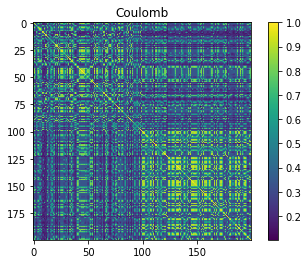

In [393]:
plt.imshow(np.exp(-adj_mat/np.mean(adj_mat)))
plt.title('Coulomb')
plt.colorbar()

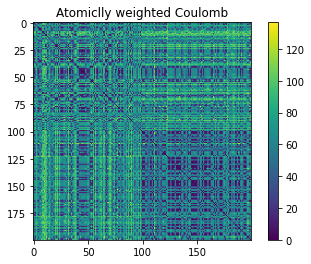

In [394]:
plt.imshow(adj_mat)
plt.title('Atomiclly weighted Coulomb')
plt.colorbar()

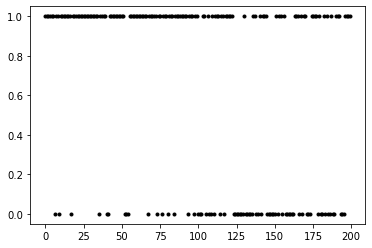

In [395]:
plt.plot(Y, 'k.')

In [402]:
_, counts_class0 = np.unique(Y[0:100], return_counts=True)

In [403]:
counts_class0.min()

16

#### Accuracy error

In [406]:
num_samples_arr = np.arange(10,200, 10)

posA = positions[state_A]
posB = positions[state_B]

perm_A = np.random.permutation(posA.shape[0])
perm_B = np.random.permutation(posB.shape[0])

errors = []
for num_samples in tqdm(num_samples_arr):
    train_A = perm_A[:num_samples]
    train_B = perm_B[:num_samples]

    C_A = similarity_matrix(posA[train_A], normalize = False, with_tqdm=False)
    C_B = similarity_matrix(posB[train_B], normalize = False, with_tqdm=False)


    adj_mat = build_adjacency_matrix(C_A + C_B, with_tqdm=False)

    classificator = SpectralClustering(n_clusters = 2, affinity='precomputed', n_init = 500)
    Y = classificator.fit_predict(np.exp(-adj_mat/np.mean(adj_mat)))
    _, counts_class0 = np.unique(Y[0:num_samples], return_counts=True)
    _, counts_class1 = np.unique(Y[num_samples:], return_counts=True)
    err_0, err_1 = np.float(counts_class0.min()/num_samples), np.float(counts_class1.min()/num_samples)
    err_tot = 0.5*(err_0 + err_1)
    errors.append([err_0, err_1, err_tot])

100%|██████████| 19/19 [08:31<00:00, 26.93s/it]


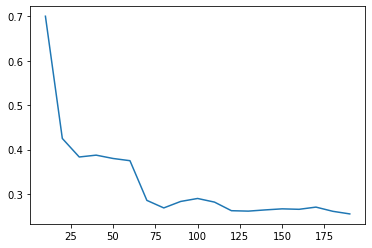

In [412]:
errors = np.array(errors)
plt.plot(num_samples_arr, errors[:,2])

In [437]:
### A more realistic example
num_samples_arr = np.arange(10,510, 10)


perm = np.random.permutation(positions.shape[0])
labels = state_A[perm]

errors = []
for num_samples in tqdm(num_samples_arr):
    train = positions[perm][:num_samples]
    true_labels = labels[:num_samples]

    C= similarity_matrix(train, normalize = False, with_tqdm=False)
    adj_mat = build_adjacency_matrix(C, with_tqdm=False)

    classificator = SpectralClustering(n_clusters = 2, affinity='precomputed', n_init = 500)
    Y = np.array(classificator.fit_predict(np.exp(-adj_mat/np.mean(adj_mat))), dtype = np.bool)
    num_A = np.count_nonzero(np.logical_xor(np.array(Y,dtype=np.bool),true_labels))
    num_B = np.count_nonzero(np.logical_xor(np.array(Y,dtype=np.bool),np.logical_not(true_labels)))
    errors.append(np.minimum(num_A,num_B)/num_samples) #Majority voting

100%|██████████| 50/50 [28:40<00:00, 34.40s/it]


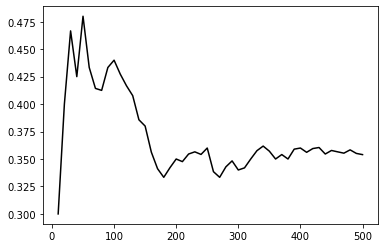

In [439]:
errors = np.array(errors)
plt.plot(num_samples_arr, errors, 'k-')

In [440]:
classificator.

SpectralClustering(affinity='precomputed', n_clusters=2, n_init=500)

In [442]:
np.count_nonzero(np.logical_not(true_labels))

382